# The Fashion MNIST - transfer learning
This is the last time we will see the **fashion MNIST dataset**. This time we will use a pretrained CNN to process the images. For every image we want to classify it into **10 distinct clothing categories**. We will use the first layers from a known CNN, **ResNet50** and only use 10% of the dataset to speed up processing.

The **ResNet50** expects the input to have **3 colors**, but the Fashion MNIST dataset is only grayscale. We will "fix" this issue by copying the grayscale values as the colors Red, Green, Blue. These images will undboutably look strange, but this allows us to use the ResNet50 model. Furthermore, the minimal image input size is **32 by 32** pixels, and our images are 28 by 28. To fix this, we will resize our images. Thus, our training set will have dimensions `(6000, 32, 32, 1)`. Lastly, we will do our normal **Min/Max scaling** and map the labels to their **one-hot encoding representation**. 

We will then download the ResNet50 model and chop off the last layers. We will then construct a new model which uses the first layers of the ResNet50 as the input layer and **freeze** the weights, so we do not train them. After feeding the input to the ResNet50 we will use the computed representation as input to a **dense layer** and then to a **softmax layer**. This will allow us to output a 10 class probability distribution specific to our problem and train the CNN using **categorical_crossentropy**. 

Let's load the data set and inspect the dimensions.

In [1]:
library(tensorflow)
library(keras)
library(abind)
source("06-helpers.R")

use_multi_cpu(4L)

data <- dataset_fashion_mnist()
dim(data$train$x)
length(data$train$y)
dim(data$test$x)
length(data$test$y)

[1] 60000    28    28

[1] 60000

[1] 10000    28    28

[1] 10000

## 1.1 Reshape and subsampling
For our purposes we will only work with a small number of examples this time, 6000 training examples and 1000 testing examples. Otherwise processing times might become too long. Our first step is to reshape the data, to add one extra dimension for the colors. We reshape a subsample of the data.

In [17]:
x_train_reshaped <- array_reshape(x = data$train$x[1:6000,,], dim = c(6000, 28, 28, 1))
x_test_reshaped <- array_reshape(x = data$test$x[1:1000,,], dim = c(1000, 28, 28, 1))
dim(x_train_reshaped)
dim(x_test_reshaped)

[1] 6000   28   28    1

[1] 1000   28   28    1

## 1.2 Stacking/concatenating arrays
Since we only have one color value now and the ResNet expects 3 colors, we will copy the color value we have two more times. We do this by stacking the original color values together. To understand what is happening, think of a book, the book represents a single black and white picture. Then duplicate the book until we have 3 copies. Then we glue them together to create one book which is three times thicker by stacking the books in order. This is effectively what we are doing.

To do this we use the function `abind`. Run the code below to get an idea how this works.

In [18]:
vector <- array(1:5, dim = c(5))
dim(vector)
vector
long_vector <- abind(vector, vector)
dim(long_vector)
long_vector

[1] 5

[1] 1 2 3 4 5

[1] 10

[1] 1 2 3 4 5 1 2 3 4 5

You can see that we just stacked/concatinated this vector to create a longer vector. Let's now try stacking these vectors so that we add the other vector as a column.

In [19]:
two_dimension <- array(1:5, dim = c(5, 1))
dim(two_dimension)
two_dimension
two_dimension_duplicated <- abind(two_dimension, two_dimension)
dim(two_dimension_duplicated)
two_dimension_duplicated

[1] 5 1

1
2
3
4
5


[1] 5 2

1,1
2,2
3,3
4,4
5,5


Now we added the vector as a new column. This then generalises to more dimensions, and in the cell below we just stack our reshaped data along the last axis.

In [20]:
dim(x_train_reshaped)
x_train_stacked <- abind(x_train_reshaped, x_train_reshaped, x_train_reshaped)
x_test_stacked <- abind(x_test_reshaped, x_test_reshaped, x_test_reshaped)
dim(x_train_stacked)
dim(x_test_stacked)

[1] 6000   28   28    1

[1] 6000   28   28    3

[1] 1000   28   28    3

## 1.3 Resizing
Now we need to make our images slightly larger by resizing them to 32 by 32 pixels. This is the minimal image size accepted. We use the `image_array_resize` function provided with Keras for this.

This cell will take about 50 seconds to run.

In [21]:
# Just to time the function
start <- Sys.time()

# Initialise our output arrays with the correct dimensions
x_train_resized <- array(0, dim = c(6000, 32, 32, 3))
x_test_resized <- array(0, dim = c(1000, 32, 32, 3))

# We iterate through the image sequentially - poor performance
for (image_index in 1:dim(x_train_stacked)[1]) {
    x_train_resized[image_index,,,] <- image_array_resize(x_train_stacked[image_index,,,],
                                                          32, 32, data_format = c("channels_last"))
}
for (image_index in 1:dim(x_test_stacked)[1]) {
    x_test_resized[image_index,,,] <- image_array_resize(x_test_stacked[image_index,,,],
                                                          32, 32, data_format = c("channels_last"))
}

end <- Sys.time()
end - start
# Check our work
dim(x_train_resized)
dim(x_test_resized)

Time difference of 38.97357 secs

[1] 6000   32   32    3

[1] 1000   32   32    3

## 1.4 Scaling
Next we scale the image using the Min/Max approach like before. Since all our features are pixel values, we just divide each feature by 255.

In [22]:
x_train <- x_train_resized/255
x_test <- x_test_resized/255

## 1.5 One-hot encoding
Lastly, the one-hot encoding.

In [23]:
y_train = to_categorical(y = data$train$y[1:6000], num_classes = 10)
y_test = to_categorical(y = data$test$y[1:1000], num_classes = 10)
dim(y_train)
dim(y_test)

[1] 6000   10

[1] 1000   10

## 2.1 ResNet50
Now we want to use the first layers of the ResNet50 model, pretrained, as feature extractors for our final model. We start by downloading the model description along with the weights. 

The ResNet50 model which we download has been trained with a known dataset called [ImageNet](http://www.image-net.org/). This is a very large dataset (14 million images) thus we can benefitted from someone else spending a long time training on this dataset. The model was trained in the multiclass classification task over 1000 classes. We do not care to classify our clothing images as these classes so we specify `include_top = FALSE`, to indicate that we will not use the last layer of the model, which is the softmax layer over 1000 classes.

In [27]:
start <- Sys.time()

k_clear_session()
resnet_50_model <- application_resnet50(weights = 'imagenet', include_top = FALSE, input_shape = c(32, 32, 3))

end <- Sys.time()
end - start

Time difference of 6.701274 secs

Let us check the layers on this model.

In [28]:
summary(resnet_50_model)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      (None, 32, 32, 3) 0                                   
________________________________________________________________________________
conv1_pad (ZeroPadding2D) (None, 38, 38, 3) 0        input_1[0][0]              
________________________________________________________________________________
conv1 (Conv2D)            (None, 16, 16, 64 9472     conv1_pad[0][0]            
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 16, 16, 64 256      conv1[0][0]                
________________________________________________________________________________
activation (Activation)   (None, 16, 16, 64 0        bn_conv1[0][0]             
________________________________________________________________________________
pool1_pad (ZeroPadding2D) (N

Wow! This is a very big model, 23 million parameters with lots of layers. In fact, processing our images through this network takes some time and we also expect the first features learned by the network to be beneficial to our problem so in the next cell we only use the layers up to the layer `activation_6`.

In [29]:
smaller_resnet_50 <- keras_model(inputs = resnet_50_model$input, 
                                 outputs = get_layer(resnet_50_model, 'activation_6')$output)

Furthermore, we do not want to train those layers. Let's make sure that we do not train all of these layers by freezing the weights.

In [30]:
freeze_weights(smaller_resnet_50)
summary(smaller_resnet_50)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      (None, 32, 32, 3) 0                                   
________________________________________________________________________________
conv1_pad (ZeroPadding2D) (None, 38, 38, 3) 0        input_1[0][0]              
________________________________________________________________________________
conv1 (Conv2D)            (None, 16, 16, 64 9472     conv1_pad[0][0]            
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 16, 16, 64 256      conv1[0][0]                
________________________________________________________________________________
activation (Activation)   (None, 16, 16, 64 0        bn_conv1[0][0]             
________________________________________________________________________________
pool1_pad (ZeroPadding2D) (N

Now we can see that there are no trainable parameters in this model. Good!

## 2.2 Our model
Let us add a dense layer and our own softmax layer to the `smaller_resnet_50` model and start training it.

Take notice of
- The first "layer" in our network is the `smaller_resnet_50` model. It takes the initial input and outputs some features.
- The small learning rate. A small learning rate is very common when training with pretrained networks.
- Long training time.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
model (Model)                       (None, 8, 8, 256)               158208      
________________________________________________________________________________
flatten_2 (Flatten)                 (None, 16384)                   0           
________________________________________________________________________________
dense_4 (Dense)                     (None, 32)                      524320      
________________________________________________________________________________
dense_5 (Dense)                     (None, 10)                      330         
Total params: 682,858
Trainable params: 524,650
Non-trainable params: 158,208
________________________________________________________________________________


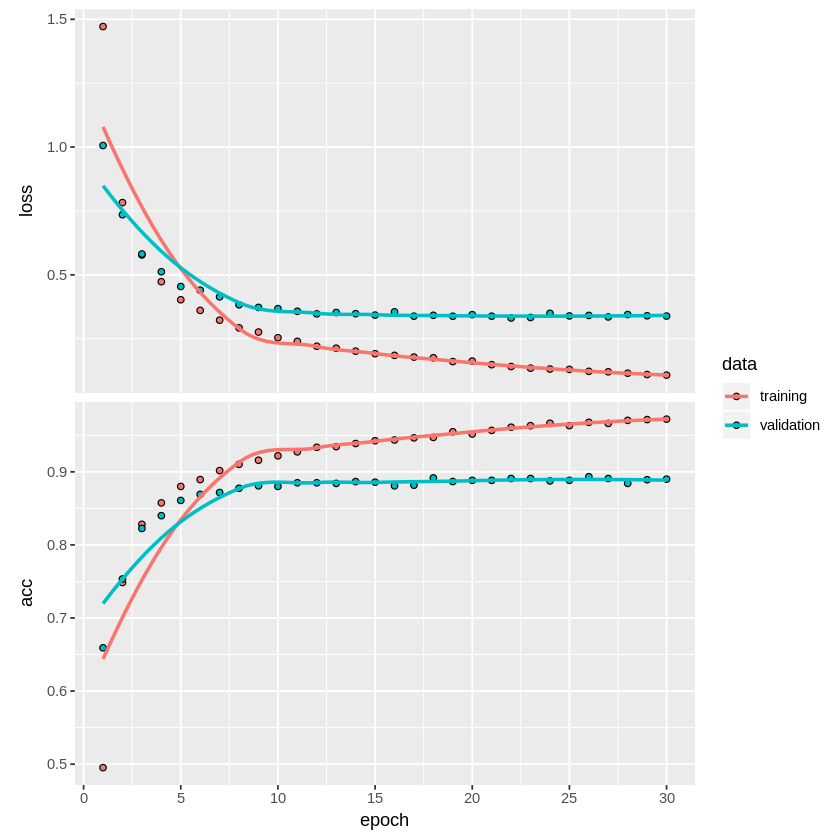

In [33]:
model <- keras_model_sequential() %>%
    smaller_resnet_50 %>%
    layer_flatten() %>%
    layer_dense(units = 32, activation = "relu") %>%
    layer_dense(units = 10, activation = "softmax")

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.0001),
    loss = "categorical_crossentropy",
    metric = "acc"
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    epochs = 20,
    batch_size = 64,
    callbacks=list(Progress$new())
)

plot(history)

From the plot we can see that our model is fairly expressive and we could maybe continue to train it and seen some performance improvements but we leave this is a bonus exercise.

In [35]:
model %>% evaluate(x_test, y_test)

$loss
[1] 3.558285

$acc
[1] 0.095

In this notebook we saw how to use a pretrained CNN and how we could add our layers to the model so that we can benefit from the generic features learned by the model. Some notes about this notebook.
- Our images are only grayscale, but the model assumed colors. We can expect this to have some negative (or at least wasted computation) on our performance.
- We needed to resize our images in order for them to fit. We can also expect this to have negative impact on performance.

## Bonus Excercise
Try improving the model above. Consider the options below
- Adding more layers from the ResNet50 model
- Adding dropout.
- Adding more dense layers/more dense units.

In [39]:
smaller_resnet_50 <- keras_model(inputs = resnet_50_model$input, 
                                 outputs = get_layer(resnet_50_model, 'activation_48')$output)
freeze_weights(smaller_resnet_50)
model <- keras_model_sequential() %>%
    smaller_resnet_50 %>%
    layer_dropout(0.2) %>%
    layer_flatten() %>%
    layer_dense(units = 32, activation = "relu") %>%
    layer_dropout(0.2) %>%
    layer_dense(units = 10, activation = "softmax")

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.0001),
    loss = "categorical_crossentropy",
    metric = "acc"
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    epochs = 20,
    batch_size = 128,
    callbacks=list(Progress$new())
)

plot(history)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
model_4 (Model)                     (None, 1, 1, 2048)              23587712    
________________________________________________________________________________
dropout_8 (Dropout)                 (None, 1, 1, 2048)              0           
________________________________________________________________________________
flatten_6 (Flatten)                 (None, 2048)                    0           
________________________________________________________________________________
dense_14 (Dense)                    (None, 32)                      65568       
________________________________________________________________________________
dropout_9 (Dropout)                 (None, 32)                      0           
________________________________________________________________________________
dense_15 (Dense)            

ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): TypeError: 'NoneType' object is not callable

Detailed traceback: 
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 880, in fit
    validation_steps=validation_steps)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_arrays.py", line 329, in model_iteration
    batch_outs = f(ins_batch)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/backend.py", line 3076, in __call__
    run_metadata=self.run_metadata)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1439, in __call__
    run_metadata_ptr)

